In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gudhi
from pogo import Pogo
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from umap import UMAP,plot
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from scipy.spatial.distance import is_valid_dm
import seaborn as sns#; sns.set_theme()


/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pogo=Pogo()

In [5]:
exprs = hf.get('exprs')
np.array(exprs)

array(['data', 'indices', 'indptr', 'shape'], dtype='<U7')

In [6]:
obs = hf.get('obs')
np.array(obs)

array(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'channel',
       'cluster', 'dataset_name', 'donor', 'free_annotation', 'gender',
       'organ', 'organism', 'platform', 'region'], dtype='<U19')

In [7]:
ground_truth = np.array(obs.get('cluster'))
ground_truth.shape

(870,)

In [8]:
uns = hf.get('uns')
np.array(uns)

array(['expressed_genes', 'scmap_genes', 'seurat_genes'], dtype='<U15')

In [9]:
data = np.array(exprs.get('data'))

In [10]:
num_rows = np.array(exprs.get('shape'))[0]
num_columns = np.array(exprs.get('shape'))[1]

In [11]:
print(num_rows)
print(num_columns)

870
23341


In [12]:
indices = np.array(exprs.get('indices'))

In [13]:
indptr = np.array(exprs.get('indptr'))

In [14]:
matrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_columns)).toarray()

In [55]:
hf = h5py.File('mouse_ES_cell.h5', 'r')
matrix = np.array(hf.get('X'))
ground_truth = np.array(hf.get('Y'))

In [56]:
print(matrix.shape)
matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [1, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int32)

In [57]:
cmdist = pdist(matrix, 'correlation')

In [58]:
cmdist.shape

(3689686,)

In [59]:
mdist = squareform(cmdist, force='no', checks=True)

In [60]:
mdist.shape

(2717, 2717)

In [61]:
mdist

array([[0.        , 0.21634314, 0.22286798, ..., 0.42067942, 0.37501874,
        0.55173327],
       [0.21634314, 0.        , 0.15345263, ..., 0.35932975, 0.30804011,
        0.50591949],
       [0.22286798, 0.15345263, 0.        , ..., 0.35424044, 0.28403244,
        0.4769104 ],
       ...,
       [0.42067942, 0.35932975, 0.35424044, ..., 0.        , 0.24696374,
        0.41904049],
       [0.37501874, 0.30804011, 0.28403244, ..., 0.24696374, 0.        ,
        0.37856029],
       [0.55173327, 0.50591949, 0.4769104 , ..., 0.41904049, 0.37856029,
        0.        ]])

In [62]:
is_valid_dm(mdist)

True

In [63]:
#Heatmap

#ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

#plt.title('Heatmap')
#plt.savefig('heatmap',dpi=100)

In [64]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)
kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=42)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]

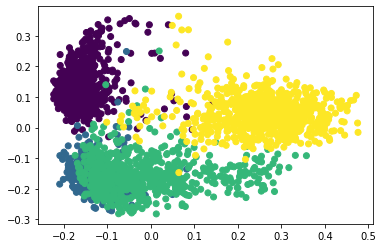

In [65]:
plt.scatter(X,y,c=ground_truth)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Text(0.5, 1.0, 'Unlabeled UMAP Embedding in 2D')

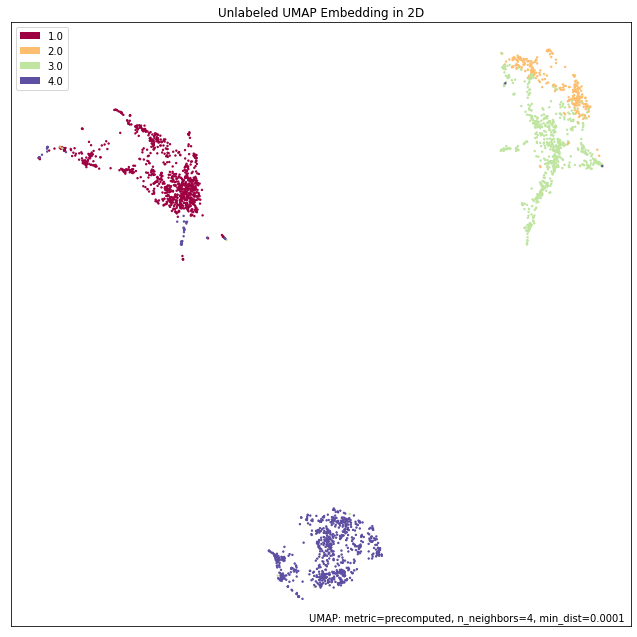

In [66]:
#Create 2-d umap dimensionality reduction embedding to visualize unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4)
umap_embedding = umap_model_2d.fit_transform(mdist)
plot.points(umap_model_2d,labels=ground_truth)

plt.title('Unlabeled UMAP Embedding in 2D')

In [67]:
umap_embedding.shape

(2717, 2)

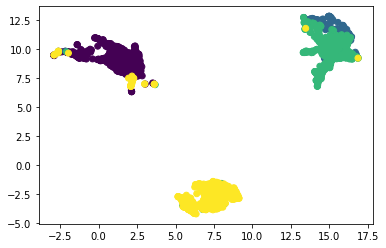

In [68]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],c=ground_truth)

In [69]:
umap_model_33d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=33)
umap_embedding_33d = umap_model_33d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


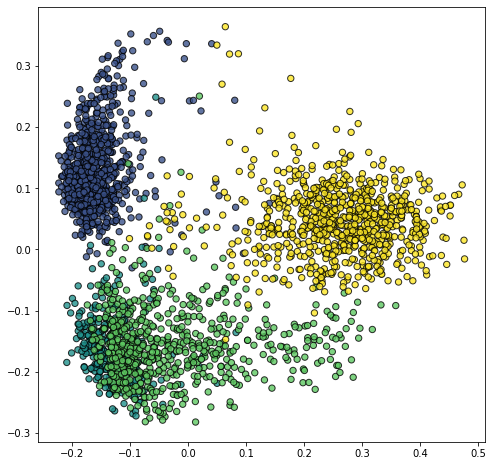

In [70]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)
kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=0)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            c=ground_truth,
            marker="o",
            #cmap=viridis,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

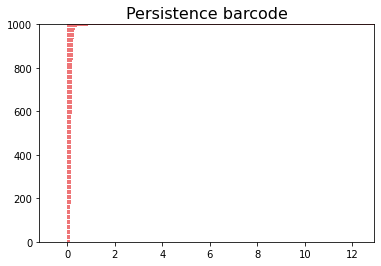

In [71]:
rips_complex = gudhi.RipsComplex(points=umap_embedding_33d)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
diag = simplex_tree.persistence()

gudhi.plot_persistence_barcode(diag)
plt.show()

In [72]:
persistence_module = simplex_tree.persistence()

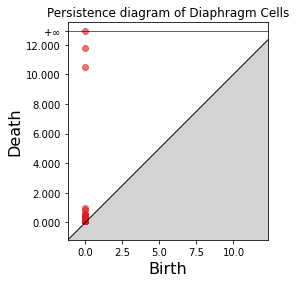

In [73]:
ax = gudhi.plot_persistence_diagram(persistence=persistence_module)
# We can modify the title, aspect, etc.
ax.set_title("Persistence diagram of Diaphragm Cells")
ax.set_aspect("equal")  # forces to be square shaped
plt.show()

In [ ]:

pogo.fit(mdist)
pogo.plot()

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [ ]:
pogo.idx_

In [ ]:
pogo.labels_

In [ ]:
pogo.candidates_

In [ ]:
plt.plot(pogo.gap_vector_)

In [ ]:
silhouette_indices, silhouette_array = pogo.plot_silhouette()

In [ ]:
score_indices, score_array = pogo.plot_silhouette_score()

In [ ]:
pogo.plot(13636)

In [ ]:
rand_indices, rand_array = pogo.plot_rand_score(ground_truth)


In [ ]:
max(rand_array)

In [ ]:
plt.scatter(umap_embedding_33d[:,0],umap_embedding_33d[:,1],c=ground_truth)